In [2]:
# Import statements
from full_spectrum_plot import plot_spectrum
from astropy.stats import mad_std
from astropy.io import fits
from spectral_cube import OneDSpectrum
from astropy import units as u
import pyspeckit
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore')

# Define directory we're working with
results = '/blue/adamginsburg/abulatek/brick/symlinks/imaging_results/spectra/'

In [3]:
# Get names of spectral windows
# I think these are in vaguely the right order?
freq_spws = [
'87_spw25',
# '87_spw102', # duplicate of above
'89_spw27',
# '89_spw104', # duplicate of above

'91_spw25', 
# '91_spw102', # duplicate of above
'93_spw27',
# '93_spw104', # duplicate of above
'95_spw25', 
'97_spw27', 
'98_spw29',
# '98_spw106', # duplicate of above
# '99_spw25', # duplicate of above
'99_spw31',  
# '99_spw108', # duplicate of above

# '101_spw27', # duplicate of above
'102_spw23',
'102_spw29', 
# '102_spw106', # duplicate of above
'104_spw25',
'103_spw31', 
# '103_spw108', # duplicate of above
'106_spw29',
'107_spw31',

'110_spw29',
'111_spw31',
'112_spw27',
'114_spw29',

'127_spw65', 
'129_spw67',

'130_spw105',
'132_spw107',
'134_spw45', 
'135_spw47',
'137_spw85',
'137_spw69',
# '139_spw87', # duplicate of above
'139_spw71',
# '141_spw25', # duplicate of above

'140_spw109',
'142_spw111',
'144_spw49',
'146_spw51',
'147_spw89',
'149_spw91',

'142_spw27', # mislabeled
# '151_spw29', # duplicate of above
'152_spw31',

'244_spw65',
'245_spw67',
'247_spw105',
'249_spw107',

'250_spw25',
'252_spw27',
'254_spw85',
'255_spw87',
'257_spw45',
'259_spw47',
# '258_spw69', # significant overlap with above?
'259_spw71',

'261_spw109',
'263_spw111',
'264_spw29',
'266_spw31',
'268_spw89',

'270_spw91',
'271_spw49',
'273_spw51'
]

In [4]:
# Create list of filenames and plot spectral coverage of our spectral windows
max_fns = []
spectra = []
for i in range(len(freq_spws)):
    max_fn = results+'source_ab_'+freq_spws[i]+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
    max_fns.append(max_fn)
    sp = OneDSpectrum.from_hdu(fits.open(max_fns[i])).to(u.K)
    sp = pyspeckit.Spectrum.from_hdu(sp.hdu)
#     sp.baseline()
    sp.data -= np.median(sp.data)
#     sp.plotter()
    spectra.append(sp)
#     print(i,': ',freq_spws[i])
#     plot_spectrum(max_fn)

In [5]:
'''Spectrum interpolation method (maybe easier to conceptualize?)'''
# Divide total spectral space into 1 GHz bins
bin_size = 1.0e9
freq_bin_edges = np.arange(spectra[0].xarr[0].value, spectra[-1].xarr[-1].value, bin_size)
freq_bin_centers = np.arange(spectra[0].xarr[0].value + 0.5*bin_size, 
                             spectra[-1].xarr[-1].value - 0.5*bin_size, bin_size)

step_size = spectra[0].xarr[1] - spectra[0].xarr[0] # get step size from spectrum

binned_spectra = [] # Collect spectrum for each bin
sigmas = [] # Collect sigma values for each bin
fractions = [] # Collect fractions of bin bandwidth that are above 7 sigma
# Loop over each bin
for edge_i in range(len(freq_bin_centers)): 
    ll, ul = freq_bin_edges[edge_i]*u.Hz, freq_bin_edges[edge_i+1]*u.Hz # I had this as GHz oops
    
    overlapping_spws = [] # Collect indices of spws that overlap with bin
    # Loop over each spectral window
    for spectrum_i in range(len(spectra)):
        # Check for overlap between the bin and the spectral window
        ll_in_spw = spectra[spectrum_i].xarr.in_range(ll)
        ul_in_spw = spectra[spectrum_i].xarr.in_range(ul)
#         print("Bin limits:", ll.to(u.GHz), ul.to(u.GHz))
#         print("Spectral window limits:", spectra[spectrum_i].xarr[0].to(u.GHz),
#              spectra[spectrum_i].xarr[-1].to(u.GHz))
#         print(ll_in_spw, ul_in_spw)
        if ll_in_spw or ul_in_spw:
            overlapping_spws.append(spectrum_i)
#     print(overlapping_spws)
            
    # If there are no spws that overlap with bin, set fraction to nan so they're not plotted
    if len(overlapping_spws) == 0:
        frac = np.nan
        fractions.append(frac)
    
    else:
        # Create x-axis from bin and interpolate all spectra onto that x-axis
        xarr = pyspeckit.units.SpectroscopicAxis(np.arange(ll.value, ul.value, step_size.value)*u.Hz)
        
        interp_spectra = []
        # Grab correct spectra from list of overlapping spws to interpolate over for this bin
        for spw_i in overlapping_spws:
            interp_spectrum = pyspeckit.spectrum.interpolation.interp_on_axes(spectra[spw_i], xarr)
            interp_spectra.append(interp_spectrum)

        # Average all spectra together
        if len(interp_spectra) == 1:
#             print("Single spectrum")
            spec_average = interp_spectra[0]
        if len(interp_spectra) > 1:
#             print("Averaged spectrum")
            spec_all = pyspeckit.spectrum.classes.ObsBlock(interp_spectra)
            spec_average = spec_all.average()

        # Convert all 0's in averaged spectrum to nan
        spec_average.data[spec_average.data == 0] = np.nan
        binned_spectra.append(spec_average)
            
        # Calculate MAD-estimated RMS of averaged spectrum
        sigma = mad_std(spec_average.data, ignore_nan = True) # in K
        sigmas.append(sigma)
#         print(7.0*sigma)
        above_7_sigma_mask = spec_average.data > 7.0*sigma

        # Calculate fraction of averaged spectrum above 7*sigma
        frac = np.count_nonzero(above_7_sigma_mask)/len(above_7_sigma_mask) # frac in mask
        fractions.append(frac)

In [6]:
# plt.figure(figsize=(9, 5))
# plt.plot(freq_bin_centers*(1/(10.**9)), freq_bin_centers/freq_bin_centers, marker=',')
# plt.xlabel('Center frequency (GHz)')
# plt.ylabel('Arbitrary 1')
# plt.title('Bin centers')
# plt.show()

Center (GHz): 115.05157773300688
Sigma: 0.08723870870233393
7*sigma 0.6106709609163374
Fraction above 7*sigma: 0.11414634146341464


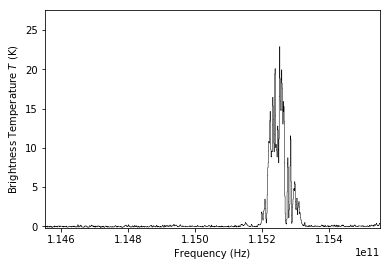

In [7]:
ind = 29
print("Center (GHz):",freq_bin_centers[ind]*(1/(10.**9)))
print("Sigma:",sigmas[ind])
print("7*sigma",7*sigmas[ind])
print("Fraction above 7*sigma:",fractions[ind])

sp_ind = binned_spectra[ind]
sp_ind.plotter()

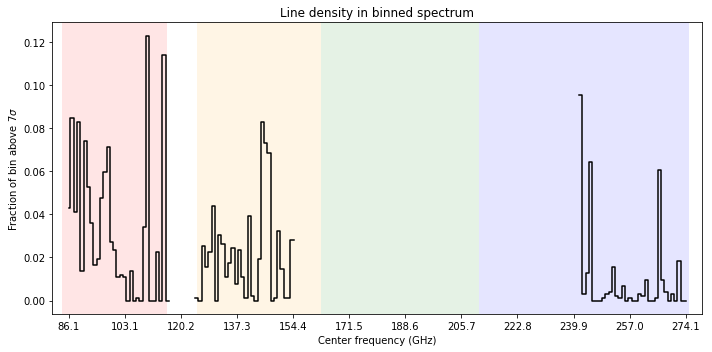

In [43]:
import matplotlib.patches as mpatches
plt.figure(figsize=(10, 5))
plt.plot(freq_bin_centers*(1/(10.**9)), fractions, linestyle = '-', color = 'k', drawstyle = 'steps-mid')
plt.xlabel('Center frequency (GHz)')
plt.ylabel('Fraction of bin above $7\sigma$')
plt.title('Line density in binned spectrum')
plt.xlim(np.min(freq_bin_centers*(1/(10.**9)))-5, np.max(freq_bin_centers*(1/(10.**9)))+5)
plt.xticks(np.linspace(np.min(freq_bin_centers*(1/(10.**9))), np.max(freq_bin_centers*(1/(10.**9))), 12))
plt.tight_layout()
band3 = mpatches.Rectangle((84, -0.02), (116. - 84.), 0.2, alpha = 0.1, facecolor = "red")
band4 = mpatches.Rectangle((125, -0.02), (163. - 125.), 0.2, alpha = 0.1, facecolor = "orange")
band5 = mpatches.Rectangle((163, -0.02), (211. - 163.), 0.2, alpha = 0.1, facecolor = "green")
band6 = mpatches.Rectangle((211, -0.02), (275. - 211.), 0.2, alpha = 0.1, facecolor = "blue")
plt.gca().add_patch(band3)
plt.gca().add_patch(band4)
plt.gca().add_patch(band5)
plt.gca().add_patch(band6)
plt.savefig('line_density_diff_range3.png', dpi = 200)
plt.show()

### Abandoned code below

In [ ]:
'''This is used for the next cell, which is the method I have abandoned.'''
# # Loop through every spectral window and estimate the the RMS with MAD (spws are noise-dominated)
# # Plot RMS estimate (MAD) in each spectral window
# center_freqs = []
# mad_stds = []
# for i in range(len(freq_spws)):
#     center_freq = np.mean(spectra[i].xarr)
#     sigma = mad_std(spectra[i].data, ignore_nan=True) # in K?
#     center_freqs.append(center_freq.value)
#     mad_stds.append(sigma)
# center_freqs = np.array(center_freqs)
    
# plt.figure(figsize=(9, 5))
# plt.scatter(center_freqs*(1/(10.**9)), mad_stds)
# plt.xlabel('Center frequency (GHz)')
# plt.ylabel('MAD-estimated standard deviation (K)')
# plt.title('Standard deviation per spectral window')
# plt.savefig('rms_per_spw.png', dpi = 200)
# plt.show()

In [ ]:
'''This is the "cases" way of doing this, which I am giving up on for now (4/20).
Uncomment all lines to be able to use.'''
# # Divide total spectral space into 1 GHz bins
# bin_size = 1.0e9
# freq_bin_edges = np.arange(spectra[0].xarr[0].value, spectra[-1].xarr[-1].value, bin_size)
# freq_bin_centers = np.arange(spectra[0].xarr[0].value + 0.5*bin_size, 
#                              spectra[-1].xarr[-1].value - 0.5*bin_size, bin_size)

# fractions = [] # initialize array of fractional bandwidths above 7 sigma
# found_a_case = 0 # initialize count of found cases

# for edge_i in range(len(freq_bin_centers)):
#     found = False # we have not found a spw case yet
#     ll, ul = freq_bin_edges[edge_i]*u.Hz, freq_bin_edges[edge_i+1]*u.Hz # I had this as GHz oops
# #     print("Edge",edge_i)
    
#     for spectrum_i in range(len(spectra)):
# #         print("Spectrum",spectrum_i)
        
#         ll_in_spw = spectra[spectrum_i].xarr.in_range(ll)
#         ul_in_spw = spectra[spectrum_i].xarr.in_range(ul)
#         ll_in_last_spw = False
#         if spectrum_i != 0:
#             ll_in_last_spw = spectra[spectrum_i-1].xarr.in_range(ll)
#             ul_in_last_spw = spectra[spectrum_i-1].xarr.in_range(ul)
#         ul_in_next_spw = False
#         if spectrum_i != len(spectra)-1:
#             ul_in_next_spw = spectra[spectrum_i+1].xarr.in_range(ul)
#             ll_in_next_spw = spectra[spectrum_i+1].xarr.in_range(ll)
            
#         # Special cases: first and last bins, assume we're in case 1
#         # I'M NOT SUPER HAPPY WITH THIS...
#         if edge_i == 0:
#             print("Case 0")
#             found_a_case += 1
#             found = True
#             break
#         if edge_i == len(spectra)-1:
#             print("Case 0")
#             found_a_case += 1
#             found = True
#             break
        
#         # Case 1: bin is entirely in this spw, and not neighboring ones
#         if ll_in_spw and ul_in_spw and not ll_in_last_spw and not ul_in_next_spw:
#             print("Case 1")
#             found_a_case += 1
#             found = True
# #             # If both edges of bin are within one spw, calculate fraction above 7 sigma in that spw
# #             spectrum_in_bin = spectra[spectrum_i].slice(ll, ul, unit=u.Hz) # access spec in bin
# #             above_7_sigma_mask = spectrum_in_bin.data > 7.0*mad_stds[spectrum_i]
# #             frac = np.count_nonzero(above_7_sigma_mask)/len(above_7_sigma_mask) # frac in mask
# #             fractions.append(frac)

#         # Case 2: bin overlaps with next spw, but still fully within this spw
#         if ll_in_spw and ul_in_spw and not ll_in_next_spw and ul_in_next_spw:
#             print("Case 2")
#             if found == True:
#                 raise ValueError
#             found_a_case += 1
#             found = True
    
#         # Case 2.5: mirror image of last case
#         if ll_in_spw and ul_in_spw and not ul_in_last_spw and ll_in_last_spw:
#             print("Case 2.5")
#             if found == True:
#                 raise ValueError
#             found_a_case += 1
#             found = True
        
#         # Case 3: significant overlap
#         if ll_in_spw and ul_in_spw and ul_in_next_spw and ll_in_next_spw:
#             print("Case 3")
#             if found == True:
#                 raise ValueError
#             found_a_case += 1
#             found = True
            
#         # Case 3.5: significant overlap mirrored
#         if ll_in_spw and ul_in_spw and ul_in_last_spw and ll_in_last_spw:
#             print("Case 3.5")
#             if found == True:
#                 raise ValueError
#             found_a_case += 1
#             found = True
        
#         # Case 4: bin is partially in this spw and next spw
        
#         # Case 4.5: mirror image of last case
        
        
#         # more cases??? jesus.
        
#         # Case 5: bin runs over edge of this spw, and there is no neighboring spw
#         if ll_in_spw and not ul_in_spw and not ul_in_next_spw:
#             print("Case 5")
#             if found == True:
#                 raise ValueError
#             found_a_case += 1
#             found = True
            
#         # Case 5.5: mirror image of last case
#         if ul_in_spw and not ll_in_spw and not ll_in_last_spw:
#             print("Case 5.5")
#             if found == True:
#                 raise ValueError
#             found_a_case += 1
#             found = True 
#             # may need to add a continue, but shouldn't need to?
            
#         # Case 6: bin not in this spectral window
#         if not ll_in_spw and not ul_in_spw:
#             if found == True:
#                 raise ValueError
#             continue # skip to next spw
        
#         if found == True:
#             break # if we found something, stop looking through spectral windows
            
#         else:
#             print("no case found")
    
#     # Case 6: if we've gone through all spws and found = False, fraction is zero for this bin
#     if found == False:
#         print("Case 6")
#         found_a_case += 1
#         frac = 0.0

# #         elif spectra[spectrum_i].xarr.in_range(ll) and not spectra[spectrum_i].xarr.in_range(ul): 
# #             # If only first edge is in spw, use this spw and the next spw to calc frac > 7 sigma
# #             sf_1 = ((spectra[spectrum_i].xarr[-1] - ll)/bin_size).value # frac of bin in 1st spw
# #             ml = spectra[spectrum_i+1].xarr[-1].value # where first part of bin ends
# #             spectrum_in_bin_1 = spectra[spectrum_i].slice(ll, ml, unit=u.Hz)
# #             above_7_sigma_mask_1 = spectrum_in_bin_1.data > 7.0*mad_stds[spectrum_i]
# #             frac_1 = np.count_nonzero(above_7_sigma_mask_1)/len(above_7_sigma_mask_1)
            
# #             if spectra[spectrum_i+1].xarr.in_range(ul): # if bin upper limit in next spw
# #                 sf_2 = 1.0 - sf_1 # fraction of bin in 2nd spw
# #                 spectrum_in_bin_2 = spectra[spectrum_i+1].slice(ml, ul, unit=u.Hz)
# #                 above_7_sigma_mask_2 = spectrum_in_bin_2.data > 7.0*mad_stds[spectrum_i+1]
# #                 frac_2 = np.count_nonzero(above_7_sigma_mask_2)/len(above_7_sigma_mask_2)
# #             else:
# #                 frac_2 = 0.0
        
# #             frac_weighted_av = frac_1*sf_1 + frac_2*sf_2 # weighted average of fractions > 7sigma
# #             fractions.append(frac_weighted_av)
            
# #         else:
# #             flag = True # raise flag because bin is not in a spectrum
# #             break
        
# #     if flag == True:
# #         fractions.append(0.0) # bin is empty
# #         flag = False   

In [ ]:
%matplotlib widget

In [ ]:
plt.figure(figsize=(9, 5))
plt.scatter(freq_bin_centers*(1/(10.**9)), fractions)
plt.xlabel('Center frequency (GHz)')
plt.ylabel('Fraction of bin above $7\sigma$')
plt.title('Line density in binned spectrum')
plt.savefig('frac_above_7sigma.png', dpi = 200)
plt.show()

In [ ]:
for i in range(len(freq_spws)):
    max_fn = results+'source_ab_'+freq_spws[i]+'_clean_2sigma_n50000_masked_3sigma_pbmask0p18.max.fits'
    print(max_fn)

In [ ]:
sp = pyspeckit.Spectrum()